In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import albumentations
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import joblib

from torch.utils.data import DataLoader, Dataset
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
from torchvision import transforms, datasets
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from torch.utils.tensorboard import SummaryWriter

### Data Loder

In [2]:
#https://debuggercafe.com/creating-efficient-image-data-loaders-in-pytorch-for-deep-learning/

In [3]:
transfrom=transforms.Compose([transforms.Resize(224),
                        transforms.CenterCrop(224),
                             transforms.ToTensor()])

In [4]:
class ImageDataset(Dataset):
    
    def __init__(self, path, labels, tfms=None):
        # data loading
        self.X = path
        self.y = labels
        
    def __getitem__(self, index):
        # dataset[0]
        image = Image.open(self.X[index]).convert('RGB')
        image = transfrom(image)
        #image = np.transpose(image, (2, 0, 1))
        type(image)
        label = self.y[index]
        return image, torch.tensor(label, dtype=torch.long)
        
    def __len__(self):
        # len(dataset)
        return(len(self.X))
    

### Model(DensNet)

In [5]:
def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

In [6]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate the input and output of each block on the channel
            # dimension
            X = torch.cat((X, Y), dim=1)
        return X

In [7]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [8]:
b1 = nn.Sequential(
    nn.Conv2d(3, 224, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(224), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [9]:
num_channels, growth_rate = 224, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # This is the number of output channels in the previous dense block
    num_channels += num_convs * growth_rate
    # A transition layer that haves the number of channels is added between
    # the dense blocks
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

### Model Traning

In [10]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [11]:
def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
           torch.nn.init.xavier_uniform_(m.weight)

In [12]:
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveMaxPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 2))

In [13]:
#create TensorBorad
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(comment="test_old_Text_analyst")

In [14]:
df = pd.read_csv('../input/data.csv')
X_ = df.image_path.values
y_ = df.target.values

In [15]:
#TODO Splite data on train and test
(xtrain, xtest, ytrain, ytest) = train_test_split(X_, y_,test_size=0.25, random_state=42)


In [16]:
train_dataset = ImageDataset(xtrain, ytrain, 0)

In [17]:
def train(num_epochs, lr_list, batch_size_list):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    for batch_size in batch_size_list:
       for lr in lr_list:
          net = nn.Sequential(
               b1, *blks,
               nn.BatchNorm2d(num_channels), nn.ReLU(),
               nn.AdaptiveMaxPool2d((1, 1)),
               nn.Flatten(),
               nn.Linear(num_channels, 2))

   
          train_data = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
          writer = SummaryWriter(comment=f' batch_size={batch_size} lr={lr}')
          optimizer = torch.optim.SGD(net.parameters(), lr=lr)
          net.apply(init_weights)
          print('training on batch_size={batch_size}, lr={lr} and ', device)
          net.to(device)
          optimizer = torch.optim.SGD(net.parameters(), lr=lr)
          loss = nn.CrossEntropyLoss()
          for epoch in range(num_epochs):
             running_loss = 0.0
             running_correct = 0
        # Sum of training loss, sum of training accuracy, no. of examples
             for i ,(X, y) in enumerate(train_data):
                X, y = X.to(device), y.to(device)
                optimizer.zero_grad()
                y_hat = net(X)

                l = loss(y_hat, y)
                running_loss += l.item()*batch_size
                running_correct += get_num_correct(y_hat, y)
            
                l.backward()
                optimizer.step()
             #fore Tensorborad
            

             writer.add_scalar('training loss',
                     running_loss,
                     epoch)
             writer.add_scalar('training correct',
                     running_correct,
                     epoch)
             # log the epoch accuracy
             writer.add_scalar('training accuracy',
                      running_correct/len(train_data),
                      epoch)
        
             for name, weight in net.named_parameters():
                writer.add_histogram(name,weight, epoch)
                writer.add_histogram(f'{name}.grad',weight.grad, epoch)
        
             print(f"Epoch {epoch+1} train loss: {running_loss/len(train_data):.3f} train acc: {running_correct/len(train_data)}")
    print('Finished Training')

In [18]:
batch_size_list = [5, 10, 20]
lr_list = [.01, .001, .0001, .00001]
num_epochs = 10
train(num_epochs, lr_list, batch_size_list)
torch.save(net.state_dict(), 'mlp.params')

training on batch_size={batch_size}, lr={lr} and  cpu


<ipython-input-4-6a56d1d4b421>:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return image, torch.tensor(label, dtype=torch.long)


Epoch 1 train loss: 10.146 train acc: 3.2
Epoch 2 train loss: 6.578 train acc: 3.4
Epoch 3 train loss: 1.744 train acc: 4.2
Epoch 4 train loss: 0.617 train acc: 4.5
Epoch 5 train loss: 0.214 train acc: 4.7
Epoch 6 train loss: 0.038 train acc: 4.8
Epoch 7 train loss: 0.027 train acc: 4.8
Epoch 8 train loss: 0.023 train acc: 4.8
Epoch 9 train loss: 0.020 train acc: 4.8
Epoch 10 train loss: 0.018 train acc: 4.8
training on batch_size={batch_size}, lr={lr} and  cpu
Epoch 1 train loss: 3.391 train acc: 3.7
Epoch 2 train loss: 2.842 train acc: 3.6
Epoch 3 train loss: 1.374 train acc: 4.1
Epoch 4 train loss: 0.353 train acc: 4.8
Epoch 5 train loss: 0.129 train acc: 4.8
Epoch 6 train loss: 0.083 train acc: 4.8
Epoch 7 train loss: 0.067 train acc: 4.8
Epoch 8 train loss: 0.058 train acc: 4.8
Epoch 9 train loss: 0.051 train acc: 4.8
Epoch 10 train loss: 0.046 train acc: 4.8
training on batch_size={batch_size}, lr={lr} and  cpu
Epoch 1 train loss: 3.830 train acc: 3.7
Epoch 2 train loss: 1.694 tr

### Evaluation Model

In [19]:
train_data = torch.utils.data.DataLoader(train_dataset, batch_size=20)
net = nn.Sequential(
               b1, *blks,
               nn.BatchNorm2d(num_channels), nn.ReLU(),
               nn.AdaptiveMaxPool2d((1, 1)),
               nn.Flatten(),
               nn.Linear(num_channels, 2))

In [20]:
writer = SummaryWriter(comment="best_old_Text_analyst")

In [21]:
def train(net, train_iter, num_epochs, lr):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
           torch.nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
         running_loss = 0.0
         running_correct = 0
        # Sum of training loss, sum of training accuracy, no. of examples
         for i ,(X, y) in enumerate(train_data):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)

            l = loss(y_hat, y)
            running_loss += l.item()
            running_correct += get_num_correct(y_hat, y)
            
            l.backward()
            optimizer.step()
            #fore Tensorborad
            

         writer.add_scalar('training loss',
                    running_loss,
                    epoch)
         writer.add_scalar('training correct',
                    running_correct,
                    epoch)
        # log the epoch accuracy
         writer.add_scalar('training accuracy',
                    running_correct/len(train_data),
                    epoch)
        
         for name, weight in net.named_parameters():
           writer.add_histogram(name,weight, epoch)
           writer.add_histogram(f'{name}.grad',weight.grad, epoch)
        
         print(f"Epoch {epoch+1} train loss: {running_loss/len(train_data):.3f} train acc: {running_correct/len(train_data)}")
    print('Finished Training')
train(net, train_data, 10, 0.001)

training on cpu


<ipython-input-4-6a56d1d4b421>:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return image, torch.tensor(label, dtype=torch.long)


Epoch 1 train loss: 0.765 train acc: 11.666666666666666
Epoch 2 train loss: 0.331 train acc: 14.333333333333334
Epoch 3 train loss: 0.147 train acc: 15.666666666666666
Epoch 4 train loss: 0.061 train acc: 16.0
Epoch 5 train loss: 0.040 train acc: 16.0
Epoch 6 train loss: 0.033 train acc: 16.0
Epoch 7 train loss: 0.028 train acc: 16.0
Epoch 8 train loss: 0.025 train acc: 16.0
Epoch 9 train loss: 0.023 train acc: 16.0
Epoch 10 train loss: 0.021 train acc: 16.0
Finished Training


In [22]:
def create_confusion_matrix(y_true, y_predicted):
    return confusion_matrix(y_true, y_predicted)

In [36]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.get_cmap('Blues')): 
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    fig =plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(ticks=range(cm.min(), cm.max() + 1, int((cm.max() - cm.min()) / 10)))

    target_names = ['0', '1']
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, "{:,}".format(cm[i, j]),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True value')
    plt.xlabel('Predicted value\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    writer.add_figure(title, fig)

In [26]:
train_dataset = ImageDataset(xtrain, ytrain, 0)
train_data = torch.utils.data.DataLoader(train_dataset)

In [27]:
#X = []
#y = []
net.to('cpu')
y_true = []
y_predicted = []
softmax = nn.Softmax(dim=1)
for (image, label) in train_data:
    y_true.append(label.detach())
    y_predicted_tensor = net(image)
    y_predicted_tensor = softmax(y_predicted_tensor)
    y_predicted.append(torch.max(y_predicted_tensor, 1)[1])

<ipython-input-4-6a56d1d4b421>:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return image, torch.tensor(label, dtype=torch.long)


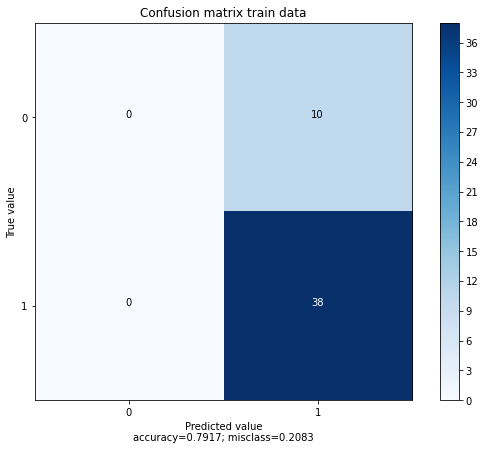

In [37]:
cm = create_confusion_matrix(y_true, y_predicted)
plot_confusion_matrix(cm, 'Confusion matrix train data')

In [ ]:
train_dataset = ImageDataset(xtest, ytest, 0)
train_data = torch.utils.data.DataLoader(train_dataset)

In [ ]:
net.to('cpu')
y_true = []
y_predicted = []
softmax = nn.Softmax(dim=1)
for (image, label) in train_data:
    y_true.append(label.detach())
    y_predicted_tensor = net(image)
    y_predicted_tensor = softmax(y_predicted_tensor)
    y_predicted.append(torch.max(y_predicted_tensor, 1)[1])

In [ ]:
cm = create_confusion_matrix(y_true, y_predicted)
plot_confusion_matrix(cm, 'Confusion matrix test data')

In [ ]:
dataiter = iter(train_data)
images, labels = dataiter.next()


In [ ]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))


In [ ]:
# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('old_text_image_images', img_grid)
net.to('cpu')
writer.add_graph(net, images)